<a href="https://colab.research.google.com/github/crux82/BISS-2024/blob/main/BISS-2024_LAB-2.1_ExtremITA_data_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Camoscio VS Minerva LLMs comparison when finetuned on the GeoLingIt dataset

The code is split into 4 steps, reflecting the following process:
- Step 1 - Encoding the data
- Step 2 - Training the models
- Step 3 - Inference: generating answers
- Step 4 - Deconding the data

## Step 1 - Encoding the data

In this Notebook we will see the encoding part of the data, given that we have some datasets each of which in its own format, in order to transform it into a sequence to sequence format. We will save the data on a file for next steps.

# The workflow

In EVALITA we have a lot of datasets (22 tasks), each of which in a different format. The annotated data consists of a straightforward tab-delimited text file:


```
<DOCID>|t|<TEXT>
<DOCID>  REL  <RML_START>-<RML_END>  <EVENT_START>-<EVENT_END>  <RML_TEXT>  <EVENT_TEXT>
<DOCID>  REL  <RML_START>-<RML_END>  <EVENT_START>-<EVENT_END>  <RML_TEXT>  <EVENT_TEXT>

<DOCID>|t|<TEXT>
<DOCID>  REL  <RML_START>-<RML_END>  <EVENT_START>-<EVENT_END>  <RML_TEXT>  <EVENT_TEXT>
```

The **objective** here is to transform this data for the LLaMA model, so we need to:
1. Transform data into sequence-to-sequence format, in order to feed it to the LLaMA model:  
  a. Read original data with pandas  
  b. Take the text after `|t|` and save it  
  c. Parse every relation `REL` into a sequence
2. Save it on file

## Input
The "input" of the Notebook is a file in the PubTator format, as given from the challenge.

## Output
The "output" (i.e. the result) of this Notebook is a simple txt file delimited by tabs, with four columns:
- id
- task name, from which the natural language task description is generated
- input text
- expected output

In [1]:
! pip3 install peft
! pip3 install sentencepiece
! pip3 install accelerate
! pip3 install bitsandbytes
! pip3 install datasets
! pip3 install spacy

Defaulting to user installation because normal site-packages is not writeable
distutils: /home/dosclic/.local/lib/python3.9/site-packages
sysconfig: /home/dosclic/.local/lib64/python3.9/site-packages
user = True
home = None
root = None
prefix = None
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
distutils: /home/dosclic/.local/lib/python3.9/site-packages
sysconfig: /home/dosclic/.local/lib64/python3.9/site-packages
user = True
home = None
root = None
prefix = None
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
distutils: /home/dosclic/.local/lib/python3.9/site-packages
sysconfig: /home/dosclic/.local/lib64/python3.9/site-packages
user = True
home = None
root = None
prefix = None
You should consider upgrading via the '/usr/bin/python -m pip 

In [2]:
! python3 -m spacy download it_core_news_sm

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 13.0 MB 4.3 MB/s eta 0:00:01
distutils: /home/dosclic/.local/lib/python3.9/site-packages
sysconfig: /home/dosclic/.local/lib64/python3.9/site-packages
user = True
home = None
root = None
prefix = None
You should consider upgrading via the '/bin/python3 -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_sm')


In [3]:
import random
from os.path import isdir
from os import mkdir, makedirs
import spacy
import re
import csv
import math
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
import csv
import json

from peft import (
    LoraConfig,
    get_peft_model,
    prepare_model_for_kbit_training,
)

import torch
from datasets import load_dataset
import pandas as pd

In [4]:
import warnings
warnings.filterwarnings('ignore')

Path to the folder 'GeoLingIt' (probably should be modified based on the user executing this notebook)

In [5]:
relPath = '.'
TASK = "geolingit"
MODEL = "ANITA"
TRAIN_DEV_SPLIT = 0.05

random.seed(23)

# How to generate the dataset

Once you have collected all the data you can encode them into the dataset format for our model, using the `encode` function.  
[On our Github repository](https://github.com/crux82/ExtremITA/tree/main/tasks) you can find all the others, but we report the `encoder` only for the CLinkaRT task:

In [6]:
nlp = spacy.load("it_core_news_sm", disable=["lemmatizer", "tagger"])



def clean_input_text(text):
    text = re.sub(r'\t+', ' ', re.sub(r'\n+', ' ', re.sub(r'\s+', " ", text)))
    text = text.rstrip()
    return text

def encode():
    if not isdir(f"out/{TASK}"):
        makedirs(f"out/{TASK}")

    for split in ['dev', 'train']:
        data = dict()

        with open(f"{relPath}/GeoLingIt/subtask_a/{split}_a.tsv", encoding="utf-8") as f:
            reader = csv.DictReader(f, delimiter="\t", quoting=csv.QUOTE_NONE)
            for row in reader:
                text = clean_input_text(row['text'])
                label = row['region']
                data[row['id']] = {
                    'text': text,
                    'label': label,
                }

        with open(f"{relPath}/GeoLingIt/subtask_b/{split}_b.tsv", encoding="utf-8") as f:
            reader = csv.DictReader(f, delimiter="\t", quoting=csv.QUOTE_NONE)
            for row in reader:
                latitude = math.floor(eval(row['latitude'])*100)/100.
                longitude = math.floor(eval(row['longitude'])*100)/100.
                data[row['id']]['latitude'] = latitude
                data[row['id']]['longitude'] = longitude

        with open(f"out/{TASK}/{split}.txt", "w", encoding="utf-8") as f_o:
            for id, features in data.items():
                f_o.write(f"{id}\t{TASK}\t{features['text']}\t[regione] {features['label']} [geo] {features['latitude']} {features['longitude']}\n")



It will generate a file for the task. In order to fine-tune the model you should merge them into one single file and split them into `train.txt` and `dev.txt`. Here we will use a subset of the training, with 100 examples per task.  
These files are made of 4 columns (with a tab character as a delimiter) without any header:
- id
- task name, from which the natural language task description is generated
- input text
- expected output

In [7]:
with open(f"{relPath}/GeoLingIt/subtask_a/train_a.tsv", "r", encoding='utf-8') as f:
  lines = f.readlines()
  for i, line in enumerate(lines):
    print(line)
    if i > 3:
      break

id	text	region

1	Non ho capito se i boni indossano le birkenstock perché sono boni o sono boni perché indossano le birkenstock	Marche

2	[USER] Ma quale mafia dice il saggio a napoli "PE FA' E FIGLI "CARRETTIERI" CE VONNO E CAZZ È "VATECAR"  per la mafia ci voglio i borsellino e i falcone no e strunz	Campania

3	in risposta ad un cazzaro virtussino, il quale dice che faranno di tutto per non farci vincere la terza stella, decisamente sono in pieno complesso di inferiorità …  “ma va a ciapà i ratt!” 🐀🐀🐀🐀  #ForzaOlimpia [URL]	Lombardia

4	POI SE BU AVANZANU ZEPPULE PASSATI DE CASA CA BU FAZZU LU CAFÈ PURTATI QUIDDRHE FRITTE CA ALLU FURNU SU TROPPU DIETETICHE 🙂	Calabria



In [8]:
encode()

Let's open the newly created file and see what's inside

In [9]:
with open(f"out/{TASK}/train.txt", "r") as f:
  lines = f.readlines()
  print(lines[0])
  print(lines[8])

1	geolingit	Non ho capito se i boni indossano le birkenstock perché sono boni o sono boni perché indossano le birkenstock	[regione] Marche [geo] 43.89 12.86

9	geolingit	[USER] Tweet veramente deleterio, specie x Gualtieri ma immagino che lei spera che perda. Sennò noi che ce stamo a ffa....	[regione] Lazio [geo] 41.89 12.54



Generating text in the ad-hoc form

In [10]:
# TODO We will probably add here the geolingit variation with the regional capital coordinates
def target_answer_to_text(target_text: str, task: str):
    if task == "geolingit":
        return target_text
    else:
        return "task sconosciuto"

def target_text_to_answer(target_text: str, task: str):
    if task == "geolingit":
        return target_text
    else:
        return "task sconosciuto"

def task_to_prompt(task: str):
    if task == "geolingit":
        return "Scrivi la regione di appartenenza di chi ha scritto questo testo, seguito dalla latitudine, seguita dalla longitudine."
    else:
        return "task sconosciuto"


 ################ GENERATE METHODS ################
def generate_prompt_pred(instruction, input_):
    return f"""Di seguito è riportata un'istruzione che descrive un task, insieme ad un input che fornisce un contesto più ampio. Scrivete una risposta che completi adeguatamente la richiesta.
### Istruzione:
{instruction}
### Input:
{input_}
### Risposta:"""

def generate_prompt_str(instruction, input_):
    return f"""Di seguito è riportata un'istruzione che descrive un task, insieme ad un input che fornisce un contesto più ampio. Scrivete una risposta che completi adeguatamente la richiesta.
### Istruzione:
{instruction}
### Input:
{input_}
### Risposta:"""

def generate_prompt(data_point):
    if data_point["input"]:
        return f"""Di seguito è riportata un'istruzione che descrive un task, insieme ad un input che fornisce un contesto più ampio. Scrivete una risposta che completi adeguatamente la richiesta.
### Istruzione:
{data_point["instruction"]}
### Input:
{data_point["input"]}
### Risposta:
{data_point["output"]}"""
    else:
        return f"""Di seguito è riportata un'istruzione che descrive un task. Scrivete una risposta che completi adeguatamente la richiesta.
### Istruzione:
{data_point["instruction"]}
### Risposta:
{data_point["output"]}"""

------------------------------
## Hyper-parameteres

Here we set all the hyper-parameters we need:
- specify the device to exploit the GPU (`cuda`)
- use the tokenizer for llama 7b
- take the base model of Camoscio from [Huggingface](https://huggingface.co/sag-uniroma2/extremITA-Camoscio-7b)
- the paths for our training and development set
- we cut off the length of sentences to maximum `512` words and `1200` charachters
- we set then the LoRA hyper-params:
  - the rank `R` of the two matrices A and B
  - the normalization factor `Alpha`
  - the `dropout rate`
  - the target modules, i.e. where to insert the LoRA modules: `q`, `k` and `v` for the attention and `o` for the final output layer.
- `number of epochs` to train the model
- `batch_size` is the global size of our batch of examples, but since we have a small GPU with only 15GB of memory, we need to scale this down, so we introduce 2 new concepts:
  - `micro_batch_size` is the real size of the batch we will use, which will be smaller (usually 2,4,8)
  - `gradient_accumulation_steps` how many steps (of batches) we want to accumulate the `loss` for before we update the parameters of the model. In this way we simulate a bigger `batch_size` by accumulating the `loss` for more than one iteration, and then we update the model.
- the `learning_rate`, which controls the intensity of the update
- the `warmup_ratio`, as we are using a scheduler for the learning rate, i.e. it will not be fixed during the whole training, but will vary based on the time.

Just to give an idea, usually you will set the learning rate to a fixed value and stick with it. That is the constant scheduler. There are different one, here after an image:

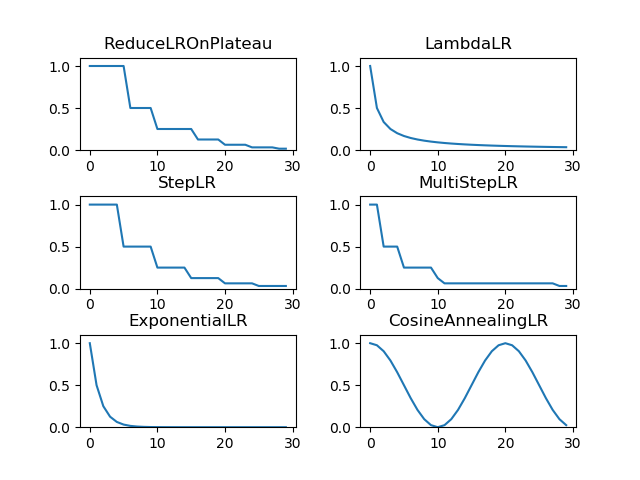

In [11]:
DEVICE = "cuda"
if MODEL == "LLaMA":
    TOKENIZER_MODEL = "yahma/llama-7b-hf"
    BASE_MODEL = "sag-uniroma2/extremITA-Camoscio-7b"
elif MODEL == "ANITA": 
    TOKENIZER_MODEL = "swap-uniba/LLaMAntino-3-ANITA-8B-Inst-DPO-ITA"
    BASE_MODEL = "swap-uniba/LLaMAntino-3-ANITA-8B-Inst-DPO-ITA"

input_train_path = f"out/{TASK}/train.txt"
input_dev_path = f"out/{TASK}/dev.txt"
OUTPUT_DIR = f"LLaMinerva/{MODEL}"

CUTOFF_LEN = 512
CUT_INPUT_CHAR_LENGTH = 1200

task = "*"

LORA_R = 8
LORA_ALPHA = 16
LORA_DROPOUT= 0.05
LORA_TARGET_MODULES = [
    "q_proj",
    "k_proj",
    "v_proj",
    "o_proj",
]

EPOCHS = 10 # better 2 epochs
BATCH_SIZE = 32 #it would be better 128 but it may require too much GPU memory (original 32)
MICRO_BATCH_SIZE = 8 #it would be better 32 but it may require too much GPU memory (original 8)
GRADIENT_ACCUMULATION_STEPS = BATCH_SIZE // MICRO_BATCH_SIZE
LEARNING_RATE = 3e-4
WARMUP_RATIO = 0.1

tmp_train_file_name = "tmp_train.json"
tmp_dev_file_name = "tmp_dev.json"

## Functions
We will define now some functions in order to facilitate the readability of the Notebook.

In [12]:
#============================================
#               FUNCTIONS
#============================================

tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_MODEL)

#LOAD INPUT TSV files in the extremITA format
def load(input_file_path):
    dataset_df = pd.read_csv(input_file_path, header=None, usecols=[0,1, 2, 3], names=['0', '1', '2', '3'], \
                             sep="\t", quoting=csv.QUOTE_NONE, encoding='utf-8').astype(str)
    dataset_df = dataset_df.rename(
        columns={"0": "id", "1": "prefix", "2": "input_text", "3": "target_text"}
    )
    dataset_df = dataset_df[["id", "input_text", "target_text", "prefix"]]
    return dataset_df


# Notice: in the generate_and_tokenize_prompt function result["labels"] is rewritten
def tokenize(prompt, cutoff_len, add_eos_token=True):
    result = tokenizer(
        prompt,
        truncation=True,
        max_length=cutoff_len,
        padding=False,
        return_tensors=None,
    )
    if (
        result["input_ids"][-1] != tokenizer.eos_token_id
        and len(result["input_ids"]) < cutoff_len
        and add_eos_token
    ):
        result["input_ids"].append(tokenizer.eos_token_id)
        result["attention_mask"].append(1)

    result["labels"] = result["input_ids"].copy()

    return result

# Notice: result["labels"] is rewritten so that only the output is considered
def generate_and_tokenize_prompt(data_point, add_eos_token=True):
    full_prompt = generate_prompt(data_point)
    tokenized_full_prompt = tokenize(full_prompt, CUTOFF_LEN)

    user_prompt = generate_prompt_str(
        data_point["instruction"], data_point["input"]
    )
    tokenized_user_prompt = tokenize(
        user_prompt, CUTOFF_LEN, add_eos_token=add_eos_token
    )
    user_prompt_len = len(tokenized_user_prompt["input_ids"])

    if add_eos_token:
        user_prompt_len -= 1

    tokenized_full_prompt["labels"] = [
        -100
    ] * user_prompt_len + tokenized_full_prompt["labels"][
        user_prompt_len:
    ]  # could be sped up, probably
    return tokenized_full_prompt



def load_and_prepare_data(input_file_path: str, tasks):

    df = load(input_file_path)

    if isinstance(tasks, str):
        if(tasks != "*"):
            df = df[df["prefix"]==tasks]
    elif isinstance(tasks, list):
        tmp = None
        for task in tasks:
            if tmp == None:
                tmp = df[df["prefix"]==task]
            else:
                tmp += df[df["prefix"]==task]
        df = tmp

    print(df.target_text.value_counts())

    dataset_data = [
        {
            "instruction": task_to_prompt(row_dict["prefix"]),
            "input": row_dict["input_text"],
            "output": target_text_to_answer(row_dict["target_text"], row_dict["prefix"])
        }
        for row_dict in df.to_dict(orient="records")
    ]

    return dataset_data

def trim_long_input(json_input, cutoff_len=10000000):
    for json_data in json_input:
        json_data["input"] = json_data["input"][:cutoff_len]
    return json_input


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Fine-tuning the LLM
We first load the data that was already prepared then we cut the maximum length accordingly to the previous params.

In [13]:
#-------------------
#    LOAD DATA
#-------------------
train_data = load_and_prepare_data(input_train_path, task)
dev_data = load_and_prepare_data(input_dev_path, task)


with open(tmp_train_file_name, "w") as f:
   json.dump(train_data, f)
with open(tmp_dev_file_name, "w") as f:
   json.dump(dev_data, f)

json_train = load_dataset("json", data_files=tmp_train_file_name)
json_dev = load_dataset("json", data_files=tmp_dev_file_name)

# TRIM LONG INPUT
json_train["train"] = trim_long_input(json_train["train"], CUT_INPUT_CHAR_LENGTH)
json_dev["train"] = trim_long_input(json_dev["train"], CUT_INPUT_CHAR_LENGTH)

target_text
[regione] Lazio [geo] 41.89 12.54                   4359
[regione] Campania [geo] 40.85 14.24                1607
[regione] Lombardia [geo] 45.46 9.15                 254
[regione] Lazio [geo] 41.88 12.22                    201
[regione] Sicilia [geo] 38.13 13.34                  164
                                                    ... 
[regione] Umbria [geo] 43.13 12.19                     1
[regione] Toscana [geo] 43.06 10.57                    1
[regione] Friuli-Venezia Giulia [geo] 46.14 13.1       1
[regione] Calabria [geo] 38.81 16.54                   1
[regione] Campania [geo] 40.68 14.97                   1
Name: count, Length: 1384, dtype: int64
target_text
[regione] Lazio [geo] 41.89 12.54                    73
[regione] Campania [geo] 40.85 14.24                 29
[regione] Sicilia [geo] 38.13 13.34                  16
[regione] Lombardia [geo] 45.46 9.15                 13
[regione] Liguria [geo] 44.44 8.88                   12
                             

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Now we need to load the model and its associated tokenizer. Choose here the number of bits for loading the models. Remember that lower bits mean lower precision, and thus a drop in performance.

In [14]:
bits = "4" #@param ["4", "8", "full"]

In [15]:
#-------------------
#    LOAD MODEL
#-------------------
# base model here, choose between 4, 8 bits or full precision
if bits == "8":
  model = AutoModelForCausalLM.from_pretrained(
      BASE_MODEL,
      load_in_8bit=True,
      torch_dtype=torch.float16,
      device_map="auto",
  )
elif bits == "4":
  model = AutoModelForCausalLM.from_pretrained(
      BASE_MODEL,
      load_in_4bit=True,
      torch_dtype=torch.float16,
      device_map="auto",
  )
else:
  model = AutoModelForCausalLM.from_pretrained(
      BASE_MODEL,
      torch_dtype=torch.float16,
      device_map="auto",
  )



# we need to explicitly assign the ids for the pad token, begin and end of sentence here
tokenizer.pad_token_id = 0
tokenizer.bos_token_id = 1
tokenizer.eos_token_id = 2

# we will add the pad on the left side, as to simulate an older chat history for which we don't care anymore.
# More importantly we want the model to generate on the "right" side of the sentence, as to complete a request
tokenizer.padding_side = "left"


# PREPARE DATA
train_data = ( json_train["train"].shuffle().map(generate_and_tokenize_prompt) )
val_data = ( json_dev["train"].shuffle().map(generate_and_tokenize_prompt) )

# To reduce GPU memory usage
if MODEL == "ANITA":
   model.gradient_checkpointing_enable()

# PREPARE MODEL and add the LoRA modules
model = prepare_model_for_kbit_training(model)
config = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    target_modules=LORA_TARGET_MODULES,
    lora_dropout=LORA_DROPOUT,
    bias="none",
    task_type="CAUSAL_LM",
)
model = get_peft_model(model, config)
model.print_trainable_parameters()

training_arguments = transformers.TrainingArguments(
    per_device_train_batch_size=MICRO_BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    warmup_ratio=WARMUP_RATIO,
    num_train_epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    fp16=True,
    logging_strategy = "steps",
    logging_steps=1,
    optim="adamw_torch",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    output_dir=OUTPUT_DIR,
    save_total_limit=1,
    metric_for_best_model="eval_loss",
    load_best_model_at_end=True,
    label_names=["labels"]
)

data_collator = transformers.DataCollatorForSeq2Seq(
    tokenizer, pad_to_multiple_of=8, return_tensors="pt", padding=True
)

# istantiate a Trainer object using the hyper-params we defined earlier
trainer = transformers.Trainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=val_data,
    args=training_arguments,
    data_collator=data_collator
)
model.config.use_cache = False

if torch.cuda.device_count() > 1:
    # keeps Trainer from trying its own DataParallelism when more than 1 gpu is available
    model.is_parallelizable = True
    model.model_parallel = True

# we need to explicitly assign the ids for the pad token, begin and end of sentence here
model.config.pad_token_id = 0
model.config.bos_token_id = 1
model.config.eos_token_id = 2

# speeds up training
if torch.__version__ >= "2":
    model = torch.compile(model)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Map:   0%|          | 0/13669 [00:00<?, ? examples/s]

Map:   0%|          | 0/552 [00:00<?, ? examples/s]

trainable params: 6,815,744 || all params: 8,037,076,992 || trainable%: 0.0848


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2024-05-27 11:04:46.222355: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-27 11:04:46.267474: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-27 11:04:46.267517: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFF

In [16]:
#-------------------
#    TRAIN & SAVE
#-------------------

trainer.train()

model.save_pretrained(OUTPUT_DIR)

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.40 GiB. GPU 

: 

In [ ]:
#import gc
#import torch
#del model
#gc.collect()
#torch.cuda.empty_cache()

: 